# §3 時系列データの時間依存と自己回帰モデル

In [1]:
from __future__ import unicode_literals
from __future__ import print_function
import six
import sys
import os
import math
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyper

%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'IPAexGothic'

In [2]:
sys.version

'2.7.13 |Anaconda 4.3.1 (x86_64)| (default, Dec 20 2016, 23:05:08) \n[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]'

## 演習用のデータをロード

In [3]:
r = pyper.R(use_numpy='True', use_pandas='True')

In [4]:
r('load("./cache/data.RData")')

'try({load("./cache/data.RData")})\n'

## §3-1 時間依存の表現

In [5]:
from statsmodels.tsa.stattools import acf

In [6]:
df_xprice  = pd.DataFrame(r.get('X.price'),  columns={'X.price'})
df_xreturn = pd.DataFrame(r.get('X.return'), columns={'X.return'})
df_yprice  = pd.DataFrame(r.get('Y.price'),  columns={'Y.price'})
df_yreturn = pd.DataFrame(r.get('Y.return'), columns={'Y.return'})

### 自己相関係数について

Xは1時点ずらし(lag=1)の相関係数で0.63。Yは0.023

In [7]:
acf(df_xreturn.values, nlags=4), acf(df_yreturn.values, nlags=4)

(array([ 1.        ,  0.63097735,  0.51663365,  0.44953328,  0.32406794]),
 array([ 1.        ,  0.02343057, -0.21150287,  0.01051351,  0.11402679]))

### lag=1の散布図を表示

Xの収益率は正の相関が現れている

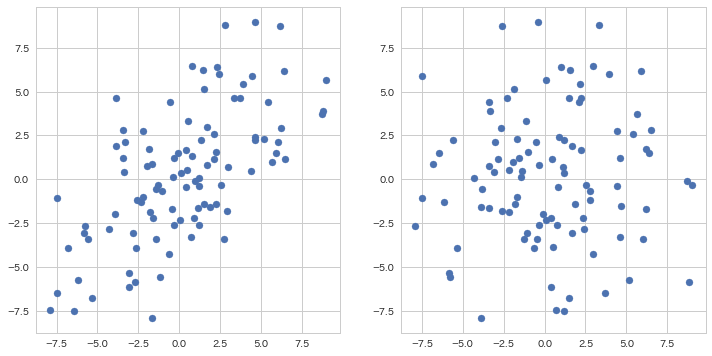

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].scatter(df_xreturn[0:-2].values, df_xreturn[1:-1].values)
axes[1].scatter(df_yreturn[0:-2].values, df_yreturn[1:-1].values)

### 収益率の偏自己相関係数をプロット (コレログラム)

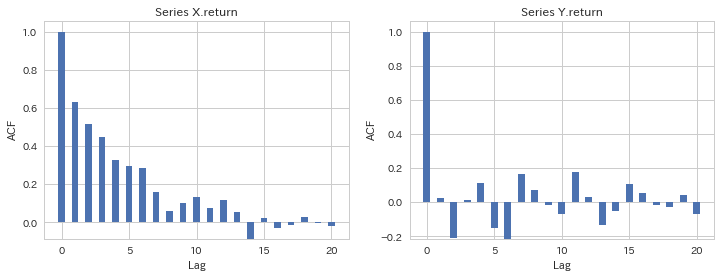

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
[ax.set_xlabel('Lag') for ax in axes]
[ax.set_ylabel('ACF') for ax in axes]

acf_xreturn = acf(df_xreturn.values, nlags=20)
axes[0].bar(range(len(acf_xreturn)), acf_xreturn, width=0.5)
axes[0].set_title('Series X.return')

acf_yreturn = acf(df_yreturn.values, nlags=20)
axes[1].bar(range(len(acf_yreturn)), acf_yreturn, width=0.5)
axes[1].set_title('Series Y.return')

### Ljung-Box検定

- https://ja.wikipedia.org/wiki/%E3%83%AA%E3%83%A5%E3%83%B3%E3%82%B0%E3%83%BB%E3%83%9C%E3%83%83%E3%82%AF%E3%82%B9%E6%A4%9C%E5%AE%9A
- 帰無仮説は「データは無作為である」=「自己相関関係を有していない」
- ここでは有意水準を10%以上とする

Xの収益率はp-val < 0.1となり、帰無仮説が棄却され、自己相関関係が認められる

In [10]:
ac, q, p = acf(df_xreturn.values, nlags=10, qstat=True)

df = pd.DataFrame(np.c_[ac[1:], q, p], columns={'ac', 'q-stat', 'p-val'})
df.ix[0,:]

ac        6.309773e-01
q-stat    4.101970e+01
p-val     1.507023e-10
Name: 0, dtype: float64

Yの収益率はp-val < 0.1とはならず、帰無仮説が採用されるため、自己相関関係が認められない

In [11]:
ac, q, p = acf(df_yreturn.values, nlags=10, qstat=True)

df = pd.DataFrame(np.c_[ac[1:], q, p], columns={'ac', 'q-stat', 'p-val'})
df.ix[0,:]

ac        0.023431
q-stat    0.056563
p-val     0.812013
Name: 0, dtype: float64

## §3-2 時系列データの性質 〜定常性について〜

(弱)定常性を持つための定義。以下の3条件を満たす

1. $E(R_{t}) = a$ : 平均が一定
2. $Var(R_{t}) = \gamma_{0}$ : 分散が一定
3. $Cov(R_{t}, R_{t-h}) = \gamma_{h}$ : 自己共分散がラグ$h$のみに依存

In [12]:
rt = df_xreturn.values
rt.shape

(100, 1)

In [13]:
np.mean(rt)

0.22802922588092248

In [14]:
np.var(rt)

14.180460231676456

In [15]:
cor = np.correlate(rt.ravel()[1:-1], rt.ravel()[0:-2], mode='full')
cor[cor.size/2:]

array([ 899.72615945,  735.01613799,  644.50945155,  462.25057899,
        421.47724413,  410.32183167,  223.96624365,   84.74534808,
        147.70289213,  183.20615838,  100.315051  ,  164.06005034,
         69.21532928, -126.40147096,   31.93950038,  -37.49600857,
        -21.68298114,   34.50394968,  -15.40289661,  -36.61787087,
        129.75824481,  128.52371909,  176.99457369,  136.83594487,
         55.77310966, -167.40399002, -169.90267955, -145.31192258,
       -207.65723338, -152.04018327, -148.06075297, -263.53787079,
       -212.00496845, -113.64262926, -164.47622134, -201.60675377,
       -235.49373707, -247.52898447, -302.03310255, -173.84298576,
       -143.78694669, -198.13806754, -151.742206  , -128.04200487,
       -149.74193732,   -6.91806223,  -55.72137404, -136.69843034,
       -152.60955698, -164.84025184, -126.87016274,  -86.18025705,
        -63.40297494, -113.02857328,  -94.47507942,  -68.80205207,
       -169.53806388, -123.48695582, -139.65027676, -275.95536

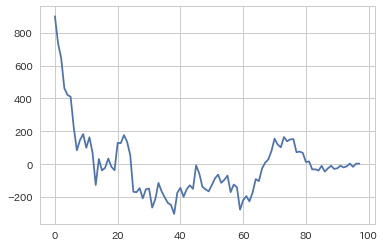

In [16]:
plt.plot(cor[cor.size/2:])

## §3-3 自己回帰モデルの導入

In [17]:
from statsmodels.tsa.ar_model import AR

In [18]:
ar_x = AR(df_xreturn.values)
res_x = ar_x.fit(ic='aic', maxlag=1)

In [19]:
res_x.params, res_x.sigma2

(array([ 0.11398896,  0.63227205]), 8.4402050554764525)

In [20]:
ar_y = AR(df_yreturn.values)
res_y = ar_y.fit(ic='aic', maxlag=1)

In [21]:
res_y.params, res_y.sigma2

(array([ 0.19506769,  0.02342876]), 14.238145768073259)

## §3-4 単位根過程について

- 自己回帰係数が $\phi_{1} = 1$ となる時系列を**単位根**をもつ時系列という
- 切片を $0$ とし単位根をもつ時系列は $R_{t} = R_{t-1} + \epsilon_{t}$ となり、差分の形は $\Delta R_{t} = \epsilon_{t}$ とホワイトノイズになる。このような系列を**ランダムウォーク**という

### Dickey-Fuller検定

- テキストで紹介しているのは「拡張ディッキー-フラー検定」のよう
- https://ja.wikipedia.org/wiki/%E6%8B%A1%E5%BC%B5%E3%83%87%E3%82%A3%E3%83%83%E3%82%AD%E3%83%BC%E2%80%93%E3%83%95%E3%83%A9%E3%83%BC%E6%A4%9C%E5%AE%9A
- 帰無仮説は「データ系列に単位根が存在する」
- ここでの有意水準を10%以上とする

In [22]:
from statsmodels.tsa.stattools import adfuller

In [23]:
df_price = pd.DataFrame(r.get('price4'))

df_price.rename(columns={' x5202 ': 'x5202',
                         ' x7272 ': 'x7272',
                         ' x4927 ': 'x4927',
                         ' x4502 ': 'x4502'},
                inplace=True)

df_price.columns

Index([u'x5202', u'x7272', u'x4927', u'x4502'], dtype='object')

In [24]:
df_return = pd.DataFrame(r.get('return4'))

df_return.rename(columns={' x5202 ': 'x5202',
                         ' x7272 ': 'x7272',
                         ' x4927 ': 'x4927',
                         ' x4502 ': 'x4502'},
                inplace=True)

df_return.columns

Index([u'x5202', u'x7272', u'x4927', u'x4502'], dtype='object')

In [25]:
# 1番目の返り値がadf値、2番目がp-value。帰無仮説は棄却できない
# regressionに何を採用すべきかいまいち不明...

adfuller(df_price['x7272'].values, regression='ctt')

(-3.1962061985558967,
 0.21062252057679709,
 0,
 120,
 {'1%': -4.4703790781250001,
  '10%': -3.5841610179398149,
  '5%': -3.8825399791666668},
 1016.6231016455624)

In [26]:
# TypeErrorが発生して検定に失敗する

adfuller(df_return['x7272'].values, regression='ctt')

TypeError: ufunc 'ndtr' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''